In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from itertools import count
import pickle
import sys
sys.path.append('..')
import brian_utils.postproc as bup
from brian2 import *

In [12]:
path = '/research/harris/prebot_opioid_model'

### Panel A

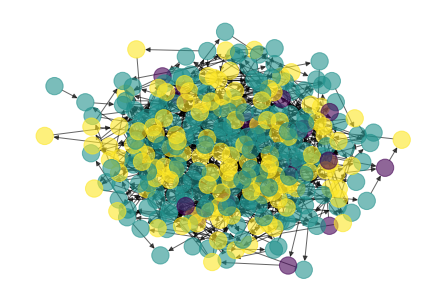

In [13]:
G = nx.read_gpickle(f'{path}/damgo_ramp_sim/networkx_objects/seed1graph.pkl')
groups = set(nx.get_node_attributes(G,'spike_type').values())
mapping = dict(zip(sorted(groups),count()))
nodes = G.nodes()
colors = [mapping[G.nodes[n]['spike_type']] for n in nodes]
sys.path.append('..')
nx.draw(G,alpha=0.6,pos=nx.kamada_kawai_layout(G), node_color = colors)
plt.savefig('fig1_networkx_graph.pdf')

### Panel B

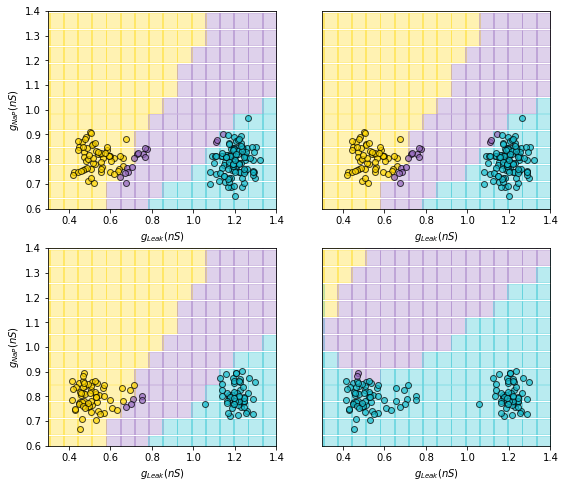

In [19]:
f = plt.figure(figsize=(9,8))
f.tight_layout()
g = f.add_gridspec(2, 2)

# pick which trial to use
run_seed = 3

data_list = []
with open(f'{path}/data/gleak_synblock_pkls/clouds_pkls/seed{run_seed}-control_clouds_vars.pkl','rb') as fid1:
    control_data = pickle.load(fid1)

with open(f'{path}/data/gleak_synblock_pkls/clouds_pkls/seed{run_seed}-damgo_clouds_vars.pkl','rb') as fid2:
    damgo_data = pickle.load(fid2)
    
with open(f'{path}/data/gleak_synblock_pkls/grid_pkls/control_grid_vars.pkl','rb') as fid1:
    grid_control_data = pickle.load(fid1)
    
with open(f'{path}/data/gleak_synblock_pkls/grid_pkls/damgo_grid_vars.pkl','rb') as fid2:
    grid_damgo_data = pickle.load(fid2)
    
data_list.append([control_data, grid_control_data, 'Control'])
data_list.append([damgo_data, grid_control_data, 'DAMGO'])

for i in [0,1]: # to handle subplotting
    data_list = []
    data_list.append([control_data, grid_control_data, 'Control'])
    if i == 0:
        data_list.append([damgo_data, grid_control_data, 'DAMGO'])
    else:
        data_list.append([damgo_data, grid_damgo_data, 'DAMGO'])
    j = 0
    for data in data_list:
        neurons = data[0]['neurongroup']
        ts = data[0]['spikemonitor']['t']
        spike_idx = data[0]['spikemonitor']['i']
        train = bup.create_train(ts,spike_idx)
        cell_int, cell_class = bup.find_bursters_pk_ISI(train,300,)

        #state = data[1]['statemonitor']
        grid_neurons = data[1]['neurongroup']
        ts = data[1]['spikemonitor']['t']
        spike_idx = data[1]['spikemonitor']['i']
        train = bup.create_train(ts,spike_idx)
        grid_cell_int, grid_cell_class = bup.find_bursters_pk_ISI(train,400,)

        ax = f.add_subplot(g[i,j])
        
#       comment this loop to get rid of phase boundaries (in case we use Illustrator or Inkscape instead)
        for neuron in range(len(grid_cell_int)):
            if grid_cell_int[neuron] == 0:
                #ax.plot(grid_neurons['g_l'][neuron]/nS, grid_neurons['g_nap'][neuron]/nS, c='tab:purple', alpha=0.3)
                ax.scatter(grid_neurons['g_l'][neuron]/nS, grid_neurons['g_nap'][neuron]/nS, c='tab:purple', marker='s', s=225, alpha=0.3)

            if grid_cell_int[neuron] == 1:
                #ax.plot(grid_neurons['g_l'][neuron]/nS, grid_neurons['g_nap'][neuron]/nS, c='gold', alpha=0.3)
                ax.scatter(grid_neurons['g_l'][neuron]/nS, grid_neurons['g_nap'][neuron]/nS, c='gold', marker='s',s=225, alpha=0.3)

            if grid_cell_int[neuron] == 2:
                #ax.plot(grid_neurons['g_l'][neuron]/nS, grid_neurons['g_nap'][neuron]/nS, c='tab:cyan', alpha=0.3)
                ax.scatter(grid_neurons['g_l'][neuron]/nS, grid_neurons['g_nap'][neuron]/nS, c='tab:cyan', marker='s',s=225, alpha=0.3)
        
        
        if i == 0:
            for neuron in range(len(cell_int)):
                if (neuron >= 0 and neuron < 60) or neuron >= 180:
                    if cell_int[neuron] == 0:
                        ax.scatter(neurons['g_l'][neuron]/nS, neurons['g_nap'][neuron]/nS, c='tab:purple', edgecolor='k', alpha=0.7)

                    if cell_int[neuron] == 1:
                        ax.scatter(neurons['g_l'][neuron]/nS, neurons['g_nap'][neuron]/nS, c='gold', edgecolor='k', alpha=0.7)

                    if cell_int[neuron] == 2:
                        ax.scatter(neurons['g_l'][neuron]/nS, neurons['g_nap'][neuron]/nS, c='tab:cyan', edgecolor='k', alpha=0.7)
        else:
            for neuron in range(len(cell_int)):
                if neuron >= 60 and neuron < 180:
                    if cell_int[neuron] == 0:
                        ax.scatter(neurons['g_l'][neuron]/nS, neurons['g_nap'][neuron]/nS, c='tab:purple', edgecolor='k', alpha=0.7)

                    if cell_int[neuron] == 1:
                        ax.scatter(neurons['g_l'][neuron]/nS, neurons['g_nap'][neuron]/nS, c='gold', edgecolor='k', alpha=0.7)

                    if cell_int[neuron] == 2:
                        ax.scatter(neurons['g_l'][neuron]/nS, neurons['g_nap'][neuron]/nS, c='tab:cyan', edgecolor='k', alpha=0.7)

        ax.set_title('')
        ax.set_xlim(0.3,1.4)
        ax.set_ylim(0.6,1.4)
        ax.set_xlabel(r'$g_{Leak} (nS)$')
        if j == 0:
            ax.set_ylabel(r'$g_{NaP} (nS)$')
        else:
            ax.set_ylabel('')
            ax.set_yticks([])
        
        j+=1
        
plt.savefig('fig1_phase_diagrams.pdf')

### Panel C

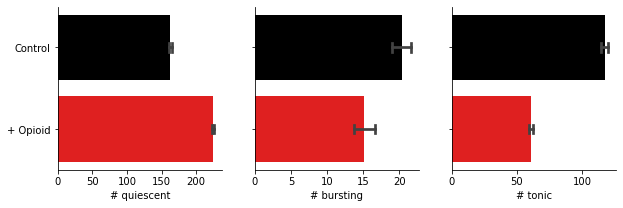

In [76]:
tbq_df = pd.read_csv(f'{path}/synblock_sim/ctrl_damgo_tbq_counts.csv')
fig, ax = plt.subplots(1,3, sharey=True, figsize=(10,3))
activity = ['quiescent', 'bursting', 'tonic']
i=0
for act in activity:
    bar_df = pd.DataFrame({f'# {act}': pd.concat([tbq_df[f'ctrl_{act[0]}_count'], tbq_df[f'damgo_{act[0]}_count']])})
    bar_df['Condition'] = np.nan
    bar_df['i'] = np.arange(0,80)
    bar_df.loc[bar_df['i'] < 40, 'Condition'] = 'Control'
    bar_df.loc[bar_df['i'] >= 40, 'Condition'] = '+ Opioid'
    sns.barplot(data=bar_df, x=f'# {act}', y='Condition', ax=ax[i], palette=['k','red'], capsize=0.1)
    ax[i].set_xlabel(f'# {act}')
    ax[i].set_ylabel('')
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    i+=1
    
plt.savefig('fig1_tbq_barplots.pdf')

### Panel D

In [5]:
shutdown_vals = pd.read_csv(f'{path}/damgo_ramp_sim/connectivity_csv/damgo_ramp_pcon_0.01.csv', usecols=['run_seed', 'I_opioid_shutdown']) 
# look at shutdown values to decide which seeds to use for the figure
shutdown_vals.head(40)

,run_seed,I_opioid_shutdown
0,1,5.400000
1,2,5.060000
2,3,5.366667
3,4,4.793333
4,5,4.573333
5,6,6.340000
6,7,5.093333
7,8,4.433333
8,9,5.160000
9,10,4.240000


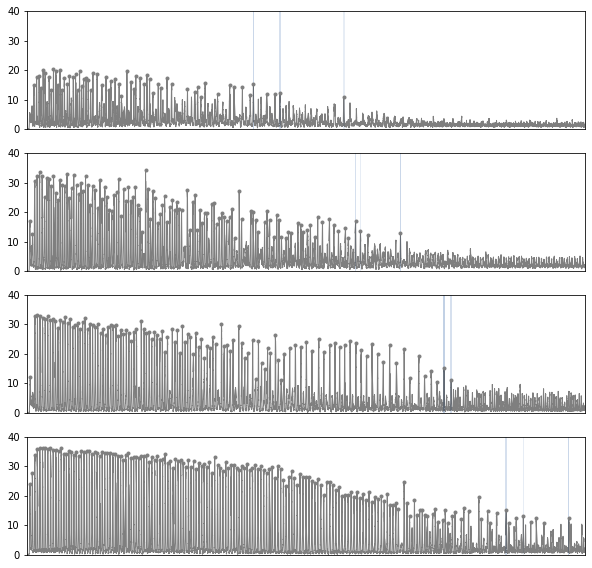

In [6]:
# plot 4 traces
fig, ax = plt.subplots(4,1, figsize=(10,10), sharex=True, sharey=True)
seeds_to_plot = [20, 9, 28, 32]
i = 0
for run_seed in seeds_to_plot:
    with open(f'{path}/data/damgo_ramp_pkls/pcon_0.01/seed{run_seed}-damgo_ramp_pcon_0.01_vars.pkl','rb') as fid1:
        data = pickle.load(fid1)
        rate1 = data['ratemonitor']

        binsize = 25 * ms 
        smoothed_pop_rate = bup.smooth_saved_rate(rate1, binsize)
        burst_stats = bup.pop_burst_stats(rate1['t'], smoothed_pop_rate, height = 4, prominence = 10)

        # mark burst peaks
        ax[i].plot(rate1['t'], smoothed_pop_rate, 'k', linewidth=1, alpha=0.5)
#         ax[i].set_xlabel('Time (s)')
#         ax[i].set_ylabel('FR\n(Hz/cell)')
        ax[i].set_xticks([])
        ax[i].set_xlim(0,600)
        ax[i].set_ylim(0,40)
        for thresh in range(10,16):
            ax[i].axvspan(burst_stats[burst_stats['Peaks'] >= thresh].iloc[-1]['Onset Times'], burst_stats[burst_stats['Peaks'] >= thresh].iloc[-1]['Offset Times'], color='lightsteelblue', alpha=0.3, lw=0)
        ax[i].plot(burst_stats['Peak Times'], smoothed_pop_rate[burst_stats['Peak Samples']], ".", c='tab:gray')
    i+=1

plt.savefig('fig1_traces.pdf')
## need to update matplotlib to put figure-level labels
# fig.supxlabel('Time (10 minutes)')
# fig.supylabel('Population Firing Rate (Hz)')
    

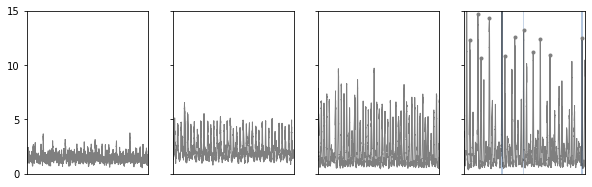

In [7]:
# Run this if you want to programatically zoom in on amplitude thresholding region (instead of just zoom in and cut/paste on Illustrator/Inkscape)
fig, ax = plt.subplots(1,4, figsize=(10,3), sharex=True, sharey=True)
seeds_to_plot = [20, 9, 28, 32]

i = 0
for run_seed in seeds_to_plot:
    with open(f'{path}/data/damgo_ramp_pkls/pcon_0.01/seed{run_seed}-damgo_ramp_pcon_0.01_vars.pkl','rb') as fid1:
        data = pickle.load(fid1)
        rate1 = data['ratemonitor']

        binsize = 25 * ms 
        smoothed_pop_rate = bup.smooth_saved_rate(rate1, binsize)
        burst_stats = bup.pop_burst_stats(rate1['t'], smoothed_pop_rate, height = 4, prominence = 10)

        onset = burst_stats[burst_stats['Peaks'] >= 16].iloc[-1]['Onset Times']
        offset = burst_stats[burst_stats['Peaks'] >= 9].iloc[-1]['Offset Times']

        # mark burst peaks
        ax[i].plot(rate1['t'], smoothed_pop_rate, 'k', linewidth=1, alpha=0.5)
        #plt.xlabel('Time (s)')
        #plt.ylabel('FR\n(Hz/cell)')
        ax[i].set_xticks([])
        ax[i].set_yticks(np.arange(0,16,5))
        ax[i].set_xlim(onset-2,offset+2)
        ax[i].set_ylim(0,15)
        for thresh in range(10,16):
            ax[i].axvspan(burst_stats[burst_stats['Peaks'] >= thresh].iloc[-1]['Onset Times'], burst_stats[burst_stats['Peaks'] >= thresh].iloc[-1]['Offset Times'], color='lightsteelblue', alpha=0.7, lw=0)
        ax[i].plot(burst_stats['Peak Times'], smoothed_pop_rate[burst_stats['Peak Samples']], ".", c='tab:gray')
    i+=1
plt.savefig('fig1_zoomed_in_traces.pdf')

### Panel E

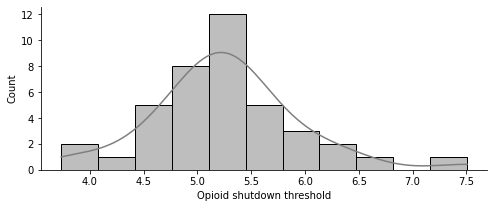

In [67]:
plt.figure(figsize=(8,3))
ax = plt.axes()
df = pd.read_csv(f'{path}/damgo_ramp_sim/connectivity_csv/damgo_ramp_pcon_0.01.csv')
sns.histplot(data=df,x='I_opioid_shutdown', kde=True, color='tab:gray', ax=ax)
ax.set_xlabel('Opioid shutdown threshold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('fig1_hist.pdf')
#sns.kdeplot(data=df,x='I_opioid_shutdown')